In [2]:
!git clone -b Use-For-MLPGAN https://github.com/ramu13/KFAC-Pytorch.git 

fatal: destination path 'KFAC-Pytorch' already exists and is not an empty directory.


In [39]:
!rm -rf KFAC-Pytorch

In [3]:
import sys
sys.path.append('/content/' + 'KFAC-Pytorch')
from optimizers import kfac

In [4]:
import PIL
PIL.PILLOW_VERSION = PIL.__version__

import torch, time, os, pickle
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.nn import Parameter
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.autograd import grad
from IPython import display
import pylab as pl
import time

%matplotlib inline

import os
os.environ['CUDA_VISIBLE_DEVICES '] = '0'

In [5]:
os.environ['CUDA_LAUNCH_BLOCKING']='1'

In [6]:
def dataloader(dataset, input_size, batch_size, split='train'):
    transform = transforms.Compose([transforms.Resize((input_size, input_size)), 
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])
    # 実装上の簡便性のため, 白黒画像を3チャンネル分コピーしてカラー画像にしている
    # mnist, fashion-mnist
    transform2 = transforms.Compose([transforms.Resize(input_size), 
                                     transforms.ToTensor(), 
                                     transforms.Lambda(lambda x: x.repeat(3,1,1)), 
                                     transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])

    
    if dataset == 'mnist':
        data_loader = DataLoader(
            datasets.MNIST('data/mnist', train=True, download=True, transform=transform2),
            batch_size=batch_size, shuffle=True)
    elif dataset == 'fashion-mnist':
        data_loader = DataLoader(
            datasets.FashionMNIST('data/fashion-mnist', train=True, download=True, transform=transform2),
            batch_size=batch_size, shuffle=True)
    elif dataset == 'cifar10':
        data_loader = DataLoader(
            datasets.CIFAR10('data/cifar10', train=True, download=True, transform=transform),
            batch_size=batch_size, shuffle=True)

    return data_loader

In [7]:
def display_process(hist, G, image_frame_dim, sample_z_, fix=True):
    plt.gcf().clear()
        
    fig = plt.figure(figsize=(24, 15))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=0.5, hspace=0.05, wspace=0.05)
        
    x = range(len(hist['D_loss']))

    y1 = hist['D_loss']
    y2 = hist['G_loss']
    
    ax1 = fig.add_subplot(1, 2, 1)

    ax1.plot(x, y1, label='D_loss')
    ax1.plot(x, y2, label='G_loss')

    ax1.set_xlabel('Iter')
    ax1.set_ylabel('Loss')

    ax1.legend(loc=4)
    ax1.grid(True)
    
    samples = G(sample_z_)
    samples = samples.cpu().data.numpy().transpose(0, 2, 3, 1)
    samples = (samples + 1) / 2

    for i in range(image_frame_dim*image_frame_dim):
        ax = fig.add_subplot(image_frame_dim, image_frame_dim*2, (int(i/image_frame_dim)+1)*image_frame_dim+i+1, xticks=[], yticks=[])
        if samples[i].shape[2]==3:
            ax.imshow(samples[i])
        else:
            ax.imshow(samples[i][:, :, 0], cmap='gray')

In [8]:
class generator(nn.Module):
    def __init__(self, input_dim=100, output_dim=1, input_size=32):
        super(generator, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_size = input_size

        self.fc = nn.Sequential(
            nn.Linear(self.input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 3*28*28),
            nn.Tanh()
        )

    def forward(self, input):
        x = self.fc(input)
        x = x.view(64, 3, 28, 28)
        return x

In [10]:
class discriminator(nn.Module):
    def __init__(self, input_dim=1, output_dim=1, input_size=32, sig_out=True):
        super(discriminator, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_size = input_size

        self.fc = nn.Sequential(
            nn.Linear(3*28*28, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, input):
        # if input.dim() >= 4:
        input = torch.flatten(torch.flatten(input, 2, 3), 1, 2)
        x = self.fc(input)
        return x

In [9]:
class GAN(object):
    def __init__(self, dataset='mnist', epoch=1):
        self.epoch = epoch
        self.sample_num = 16
        self.batch_size = 64
        self.input_size = 28
        self.z_dim = 64
        self.lrG = 0.0002
        self.lrD = 0.0002
        self.beta1 = 0.5
        self.beta2 = 0.999
        self.dataset = dataset # mnist, fashion-mnist, cifar10

        # load dataset
        self.data_loader = dataloader(self.dataset, self.input_size, self.batch_size)
        data = self.data_loader.__iter__().__next__()[0]

        # networks init
        self.G = generator(input_dim=self.z_dim, output_dim=data.shape[1], input_size=self.input_size)
        self.D = discriminator(input_dim=data.shape[1], output_dim=1, input_size=self.input_size)
        self.G_optimizer = optim.Adam(self.G.parameters(), lr=self.lrG, betas=(self.beta1, self.beta2))
        self.D_optimizer = optim.Adam(self.D.parameters(), lr=self.lrD, betas=(self.beta1, self.beta2))

        self.G.cuda()
        self.D.cuda()
        self.BCE_loss = nn.BCELoss().cuda()

        self.sample_z_ = torch.rand((self.batch_size, self.z_dim))
        self.sample_z_ = self.sample_z_.cuda()

    def train(self):
        self.train_hist = {}
        self.train_hist['D_loss'] = []
        self.train_hist['G_loss'] = []

        self.y_real_, self.y_fake_ = torch.ones(self.batch_size, 1), torch.zeros(self.batch_size, 1)
        self.y_real_, self.y_fake_ = self.y_real_.cuda(), self.y_fake_.cuda()

        self.D.train()
        for epoch in range(self.epoch):
            self.G.train()
            for iter, (x_, _) in enumerate(self.data_loader): # (batch, (x_ = (64, 3, 28, 28), _: label))
                if iter == self.data_loader.dataset.__len__() // self.batch_size:
                    break
                # zを一様分布からサンプリング
                # https://pytorch.org/docs/stable/generated/torch.rand.html
                z_ = torch.rand((self.batch_size, self.z_dim))
                x_, z_ = x_.cuda(), z_.cuda()

                # update D network
                self.D_optimizer.zero_grad()

                D_real = self.D(x_) 
                # https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html
                # y_real_ = 1, y_fake_ = 0
                D_real_loss = self.BCE_loss(D_real, self.y_real_)

                #debugging
                G_ = self.G(z_)
                D_fake = self.D(G_) 
                D_fake_loss = self.BCE_loss(D_fake, self.y_fake_)

                # 最大化→マイナスを取った値について最小化
                D_loss = D_real_loss + D_fake_loss
                self.train_hist['D_loss'].append(D_loss.item())

                D_loss.backward()
                self.D_optimizer.step()

                # update G network
                self.G_optimizer.zero_grad()

                G_ = self.G(z_)
                D_fake = self.D(G_)
                # GAN originalではなく, 勾配が消えないように工夫したloss, そのため第二引数がy_real(=1)
                # https://github.com/soumith/ganhacks のtip2
                G_loss = self.BCE_loss(D_fake, self.y_real_)
                self.train_hist['G_loss'].append(G_loss.item())

                G_loss.backward()
                self.G_optimizer.step()
                
                # ディスプレイ
                if ((iter + 1) % 10) == 0:
                    with torch.no_grad():
                        tot_num_samples = min(self.sample_num, self.batch_size)
                        image_frame_dim = int(np.floor(np.sqrt(tot_num_samples)))
                        display_process(self.train_hist, self.G, image_frame_dim, self.sample_z_)
                        display.clear_output(wait=True)
                        display.display(pl.gcf())
                        plt.close()
                       
        plt.close()
        print("Training finish!")

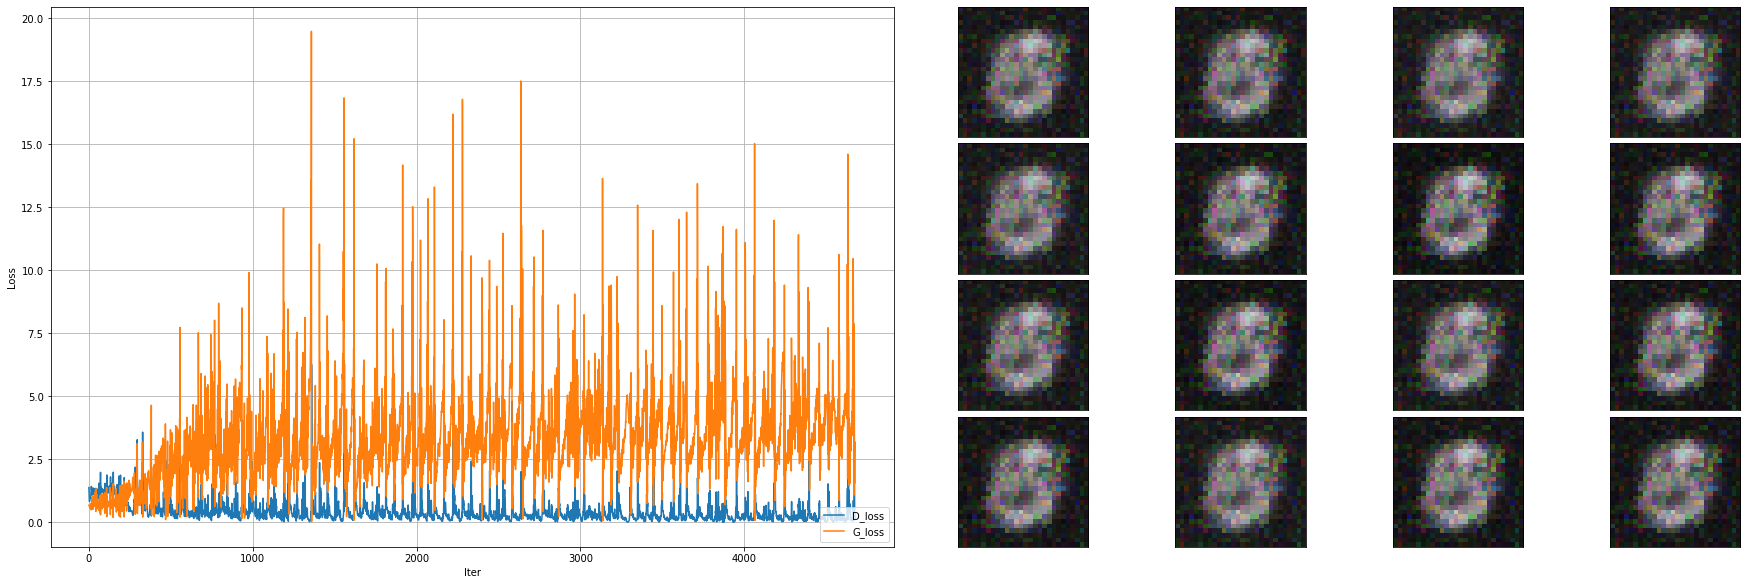

Training finish!
所要時間: 464.5043771266937


In [ ]:
import time
time_sta = time.time()
gan = GAN(epoch=5)
gan.train()
time_end = time.time()
print("所要時間: {}".format(time_end - time_sta))

In [ ]:
import time
time_sta = time.time()
gan = GAN(epoch=20)
gan.train()
time_end = time.time()
print("所要時間: {}".format(time_end - time_sta))

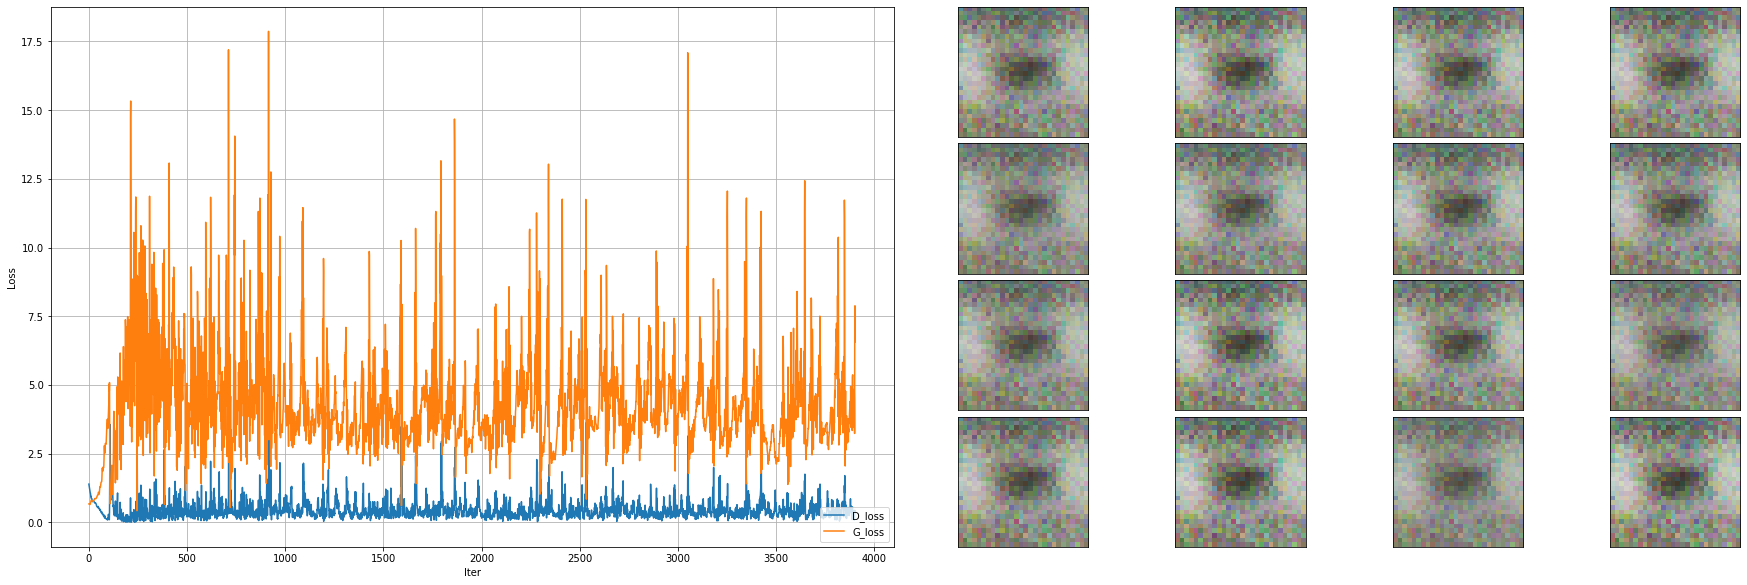

Training finish!
所要時間: 429.60551953315735


In [14]:
import time
time_sta = time.time()
gan = GAN(dataset='cifar10', epoch=5)
gan.train()
time_end = time.time()
print("所要時間: {}".format(time_end - time_sta))

In [10]:
class GAN_KFAC(object):
    def __init__(self, dataset='mnist', epoch=1):
        self.epoch = epoch
        self.sample_num = 16
        self.batch_size = 64
        self.input_size = 28
        self.z_dim = 64
        self.lrG = 0.01 #0.0001 #0.001
        self.lrD = 0.01 #0.0001 #0.001
        self.dataset = dataset # mnist, fashion-mnist, cifar10

        # load dataset
        self.data_loader = dataloader(self.dataset, self.input_size, self.batch_size)
        data = self.data_loader.__iter__().__next__()[0]

        # networks init
        self.G = generator(input_dim=self.z_dim, output_dim=data.shape[1], input_size=self.input_size)
        self.D = discriminator(input_dim=data.shape[1], output_dim=1, input_size=self.input_size)
        self.G_optimizer = kfac.KFACOptimizer(self.G, lr=self.lrG)
        self.D_optimizer = kfac.KFACOptimizer(self.D, lr=self.lrD)

        self.G.cuda()
        self.D.cuda()
        self.BCE_loss = nn.BCELoss().cuda()

        self.sample_z_ = torch.rand((self.batch_size, self.z_dim))
        self.sample_z_ = self.sample_z_.cuda()

    def train(self):
        self.train_hist = {}
        self.train_hist['D_loss'] = []
        self.train_hist['G_loss'] = []

        self.y_real_, self.y_fake_ = torch.ones(self.batch_size, 1), torch.zeros(self.batch_size, 1)
        self.y_real_, self.y_fake_ = self.y_real_.cuda(), self.y_fake_.cuda()

        self.D.train()
        for epoch in range(self.epoch):
            self.G.train()
            for iter, (x_, _) in enumerate(self.data_loader): # ( batch, 3, 28, 28 )
                if iter == self.data_loader.dataset.__len__() // self.batch_size:
                    break
                # zを一様分布からサンプリング
                # https://pytorch.org/docs/stable/generated/torch.rand.html
                z_ = torch.rand((self.batch_size, self.z_dim))
                x_, z_ = x_.cuda(), z_.cuda()

                # update D network
                self.D_optimizer.zero_grad()

                D_real = self.D(x_) # ( batch, 1 )
                # https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html
                # y_real_ = 1, y_fake_ = 0
                D_real_loss = self.BCE_loss(D_real, self.y_real_)

                G_ = self.G(z_)
                D_fake = self.D(G_)
                D_fake_loss = self.BCE_loss(D_fake, self.y_fake_)

                # 最大化→マイナスを取った値について最小化
                D_loss = D_real_loss + D_fake_loss
                self.train_hist['D_loss'].append(D_loss.item())

                D_loss.backward()
                self.D_optimizer.step()

                # update G network
                self.G_optimizer.zero_grad()

                G_ = self.G(z_)
                D_fake = self.D(G_)
                # GAN originalではなく, 勾配が消えないように工夫したloss, そのため第二引数がy_real(=1)
                # https://github.com/soumith/ganhacks のtip2
                G_loss = self.BCE_loss(D_fake, self.y_real_)
                self.train_hist['G_loss'].append(G_loss.item())

                G_loss.backward()
                self.G_optimizer.step()
                
                # ディスプレイ
                if ((iter + 1) % 10) == 0:
                    with torch.no_grad():
                        tot_num_samples = min(self.sample_num, self.batch_size)
                        image_frame_dim = int(np.floor(np.sqrt(tot_num_samples)))
                        display_process(self.train_hist, self.G, image_frame_dim, self.sample_z_)
                        display.clear_output(wait=True)
                        display.display(pl.gcf())
                        plt.close()
                       
        plt.close()
        print("Training finish!")

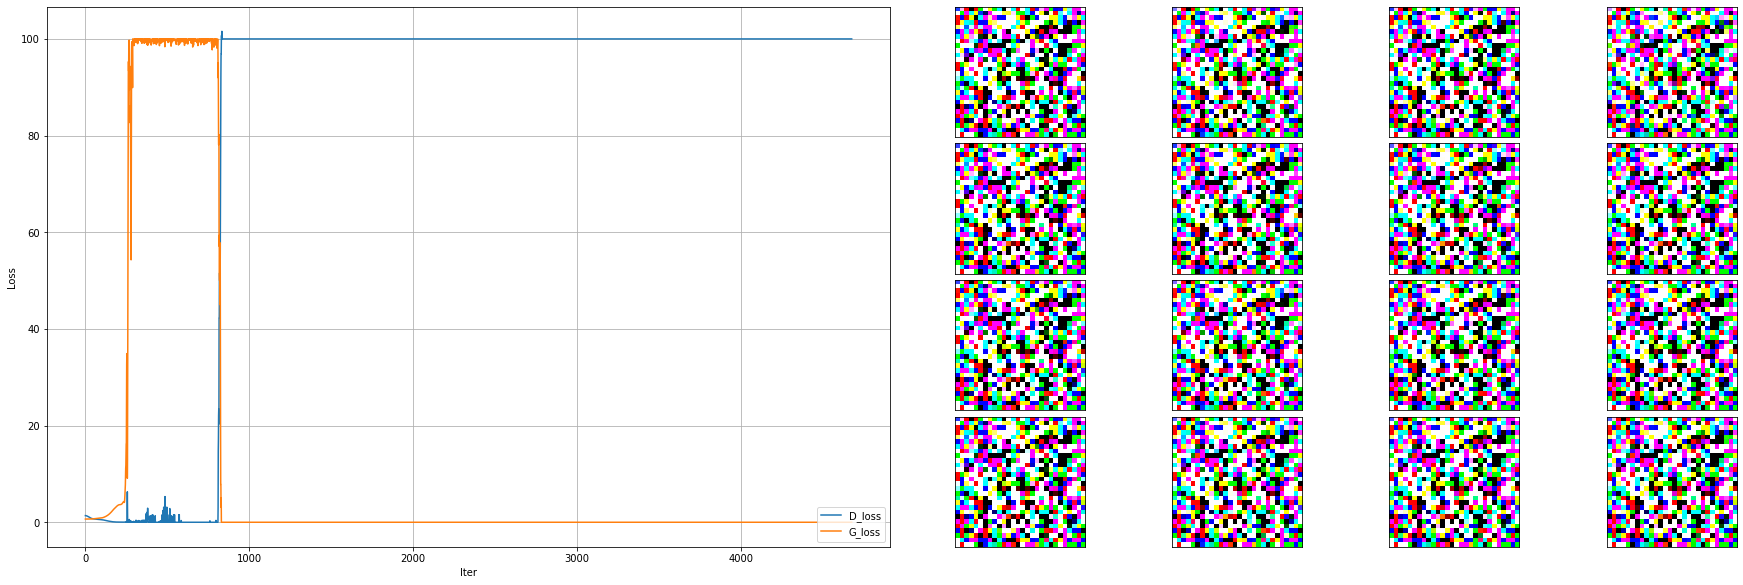

Dose Linear cause ERROR?
Dose Linear cause ERROR?
Dose Linear cause ERROR?
Dose Linear cause ERROR?
Dose Linear cause ERROR?
Dose Linear cause ERROR?
Dose Linear cause ERROR?
Dose Linear cause ERROR?
Dose Linear cause ERROR?
Dose Linear cause ERROR?
Dose Linear cause ERROR?
Dose Linear cause ERROR?
Dose Linear cause ERROR?
Dose Linear cause ERROR?
Dose Linear cause ERROR?
Dose Linear cause ERROR?
Dose Linear cause ERROR?
Dose Linear cause ERROR?
Dose Linear cause ERROR?
Dose Linear cause ERROR?
Dose Linear cause ERROR?
Dose Linear cause ERROR?
Dose Linear cause ERROR?
Dose Linear cause ERROR?
Dose Linear cause ERROR?
Dose Linear cause ERROR?
Dose Linear cause ERROR?
Dose Linear cause ERROR?
Dose Linear cause ERROR?
Dose Linear cause ERROR?
Dose Linear cause ERROR?
Dose Linear cause ERROR?
Dose Linear cause ERROR?
Dose Linear cause ERROR?
Dose Linear cause ERROR?
Dose Linear cause ERROR?
Dose Linear cause ERROR?
Dose Linear cause ERROR?
Dose Linear cause ERROR?
Dose Linear cause ERROR?


In [11]:
import time
time_sta = time.time()
gan2 = GAN_KFAC(epoch=5)
gan2.train()
time_end = time.time()
print("所要時間: {}".format(time_end - time_sta))

In [ ]:
def display_process(hist, G, image_frame_dim, sample_z_, fix=True):
    plt.gcf().clear()
        
    fig = plt.figure(figsize=(24, 15))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=0.5, hspace=0.05, wspace=0.05)
        
    x = range(len(hist['D_loss']))

    y1 = hist['D_loss']
    y2 = hist['G_loss']
    
    ax1 = fig.add_subplot(1, 2, 1)

    ax1.plot(x, y1, label='D_loss')
    ax1.plot(x, y2, label='G_loss')

    ax1.set_xlabel('Iter')
    ax1.set_ylabel('Loss')

    ax1.legend(loc=4)
    ax1.grid(True)
    
    samples = G(sample_z_)
    samples = samples.cpu().data.numpy().transpose(0, 2, 3, 1)
    # samples = (samples + 1) / 2

    for i in range(image_frame_dim*image_frame_dim):
        ax = fig.add_subplot(image_frame_dim, image_frame_dim*2, (int(i/image_frame_dim)+1)*image_frame_dim+i+1, xticks=[], yticks=[])
        if samples[i].shape[2]==3:
            ax.imshow(samples[i])
        else:
            ax.imshow(samples[i][:, :, 0], cmap='gray')

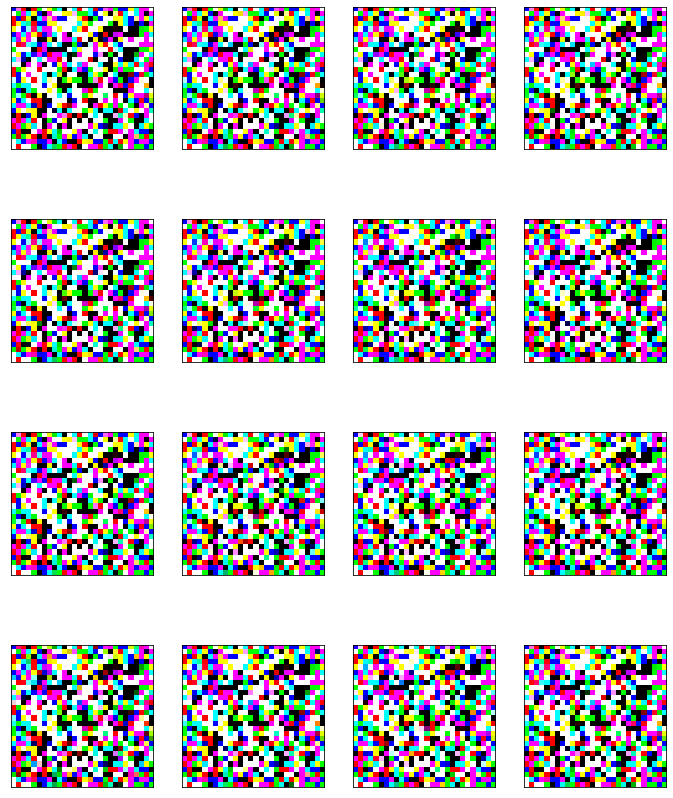

<Figure size 432x288 with 0 Axes>

In [25]:
sample_num = 16
batch_size = 64
G_input_dim = 64

with torch.no_grad():
  sample_z_ = torch.rand((batch_size, G_input_dim)).cuda()
  tot_num_samples = min(sample_num, batch_size)
  image_frame_dim = int(np.floor(np.sqrt(tot_num_samples)))

  plt.gcf().clear()
      
  fig = plt.figure(figsize=(24, 15))
    
  samples = gan2.G(sample_z_)
  samples = samples.cpu().data.numpy().transpose(0, 2, 3, 1)

  for i in range(image_frame_dim*image_frame_dim):
    ax = fig.add_subplot(image_frame_dim, image_frame_dim*2, (int(i/image_frame_dim)+1)*image_frame_dim+i+1, xticks=[], yticks=[])
    if samples[i].shape[2]==3:
      ax.imshow(samples[i])
    else:
      ax.imshow(samples[i][:, :, 0], cmap='gray')

  display.clear_output(wait=True)
  display.display(pl.gcf())
  plt.close()

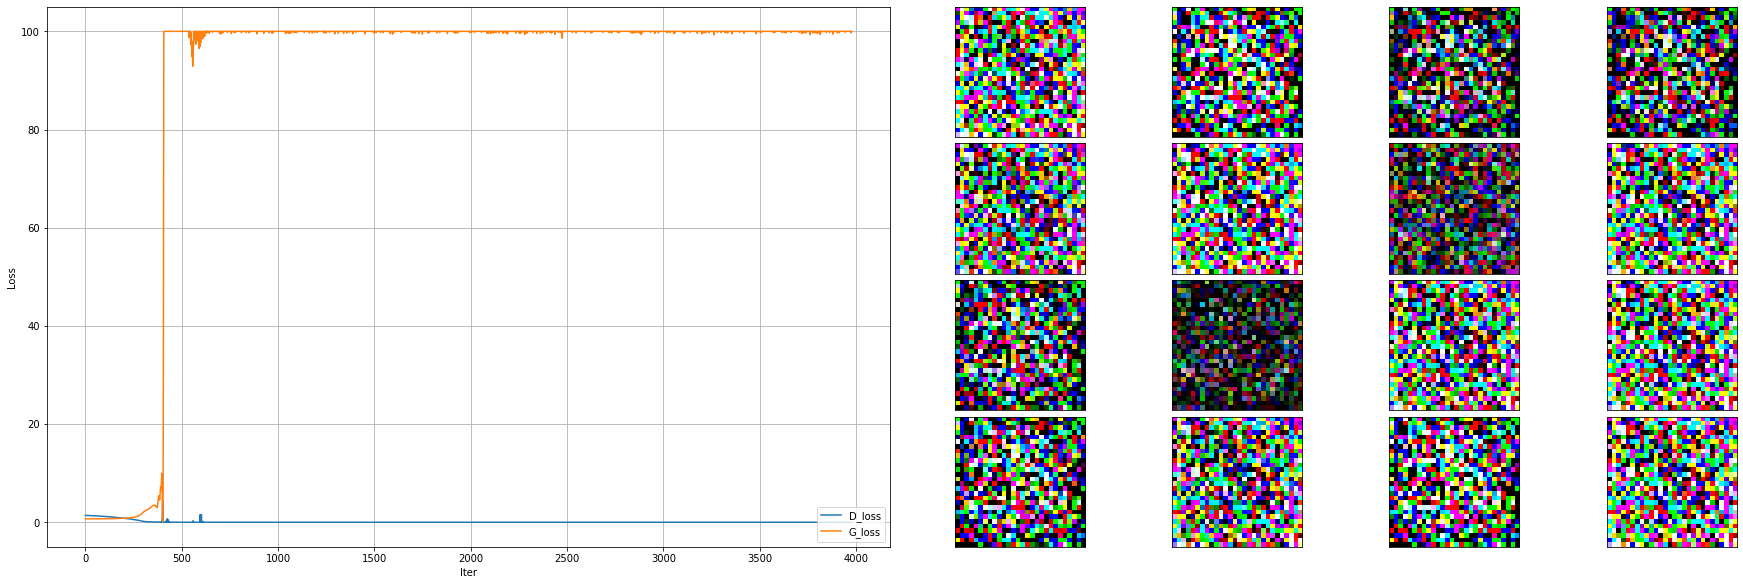

Dose Linear cause ERROR?
Dose Linear cause ERROR?
Dose Linear cause ERROR?
Dose Linear cause ERROR?
Dose Linear cause ERROR?
Dose Linear cause ERROR?
Dose Linear cause ERROR?
Dose Linear cause ERROR?
Dose Linear cause ERROR?
Dose Linear cause ERROR?
Dose Linear cause ERROR?
Dose Linear cause ERROR?
Dose Linear cause ERROR?
Dose Linear cause ERROR?
Dose Linear cause ERROR?
Dose Linear cause ERROR?
Dose Linear cause ERROR?
Dose Linear cause ERROR?
Dose Linear cause ERROR?
Dose Linear cause ERROR?
Dose Linear cause ERROR?
Dose Linear cause ERROR?
Dose Linear cause ERROR?
Dose Linear cause ERROR?
Dose Linear cause ERROR?
Dose Linear cause ERROR?
Dose Linear cause ERROR?
Dose Linear cause ERROR?
Dose Linear cause ERROR?
Dose Linear cause ERROR?
Dose Linear cause ERROR?
Dose Linear cause ERROR?
Dose Linear cause ERROR?
Dose Linear cause ERROR?
Dose Linear cause ERROR?
Dose Linear cause ERROR?
Dose Linear cause ERROR?
Dose Linear cause ERROR?
Dose Linear cause ERROR?
Dose Linear cause ERROR?


KeyboardInterrupt: ignored

<Figure size 432x288 with 0 Axes>

In [27]:
import time
time_sta = time.time()
gan3 = GAN_KFAC(epoch=5)
gan3.train()
time_end = time.time()
print("所要時間: {}".format(time_end - time_sta))

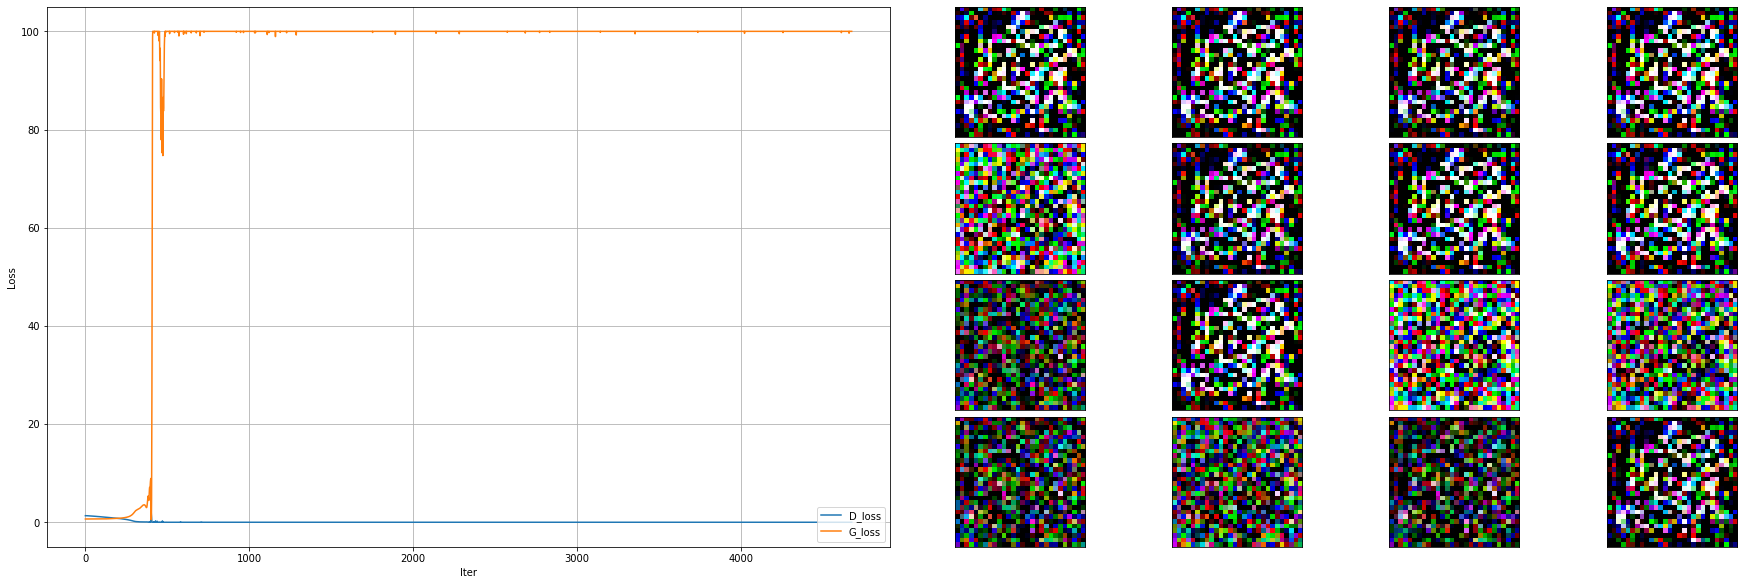

Dose Linear cause ERROR?
Dose Linear cause ERROR?
Dose Linear cause ERROR?
Dose Linear cause ERROR?
Dose Linear cause ERROR?
Dose Linear cause ERROR?
Dose Linear cause ERROR?
Dose Linear cause ERROR?
Dose Linear cause ERROR?
Dose Linear cause ERROR?
Dose Linear cause ERROR?
Dose Linear cause ERROR?
Dose Linear cause ERROR?
Dose Linear cause ERROR?
Dose Linear cause ERROR?
Dose Linear cause ERROR?
Dose Linear cause ERROR?
Dose Linear cause ERROR?
Dose Linear cause ERROR?
Dose Linear cause ERROR?
Dose Linear cause ERROR?
Dose Linear cause ERROR?
Dose Linear cause ERROR?
Dose Linear cause ERROR?
Dose Linear cause ERROR?
Dose Linear cause ERROR?
Dose Linear cause ERROR?
Dose Linear cause ERROR?
Dose Linear cause ERROR?
Dose Linear cause ERROR?
Dose Linear cause ERROR?
Dose Linear cause ERROR?
Dose Linear cause ERROR?
Dose Linear cause ERROR?
Dose Linear cause ERROR?
Dose Linear cause ERROR?
Dose Linear cause ERROR?
Dose Linear cause ERROR?
Dose Linear cause ERROR?
Dose Linear cause ERROR?


In [28]:
import time
time_sta = time.time()
gan4 = GAN_KFAC(epoch=5)
gan4.train()
time_end = time.time()
print("所要時間: {}".format(time_end - time_sta))

In [11]:
class GAN_KFAC2(object):
    def __init__(self, dataset='mnist', epoch=1, sample_num=16, batch_size=64, input_size=28, z_dim=10, lrG=0.01, lrD=0.01):
        self.epoch = epoch
        self.sample_num = sample_num
        self.batch_size = batch_size
        self.input_size = input_size
        self.z_dim = z_dim
        self.lrG = lrG
        self.lrD = lrD
        self.dataset = dataset # mnist, fashion-mnist, cifar10

        # load dataset
        self.data_loader = dataloader(self.dataset, self.input_size, self.batch_size)
        data = self.data_loader.__iter__().__next__()[0]

        # networks init
        self.G = generator(input_dim=self.z_dim, output_dim=data.shape[1], input_size=self.input_size)
        self.D = discriminator(input_dim=data.shape[1], output_dim=1, input_size=self.input_size)
        self.G_optimizer = kfac.KFACOptimizer(self.G, lr=self.lrG)
        self.D_optimizer = kfac.KFACOptimizer(self.D, lr=self.lrD)

        self.G.cuda()
        self.D.cuda()
        self.BCE_loss = nn.BCELoss().cuda()

        self.sample_z_ = torch.rand((self.batch_size, self.z_dim))
        self.sample_z_ = self.sample_z_.cuda()

    def train(self):
        self.train_hist = {}
        self.train_hist['D_loss'] = []
        self.train_hist['G_loss'] = []

        self.y_real_, self.y_fake_ = torch.ones(self.batch_size, 1), torch.zeros(self.batch_size, 1)
        self.y_real_, self.y_fake_ = self.y_real_.cuda(), self.y_fake_.cuda()

        self.D.train()
        for epoch in range(self.epoch):
            self.G.train()
            for iter, (x_, _) in enumerate(self.data_loader): # ( batch, 3, 28, 28 )
                if iter == self.data_loader.dataset.__len__() // self.batch_size:
                    break
                # zを一様分布からサンプリング
                # https://pytorch.org/docs/stable/generated/torch.rand.html
                z_ = torch.rand((self.batch_size, self.z_dim))
                x_, z_ = x_.cuda(), z_.cuda()

                # update D network
                self.D_optimizer.zero_grad()

                D_real = self.D(x_) # ( batch, 1 )
                # https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html
                # y_real_ = 1, y_fake_ = 0
                D_real_loss = self.BCE_loss(D_real, self.y_real_)

                G_ = self.G(z_)
                D_fake = self.D(G_)
                D_fake_loss = self.BCE_loss(D_fake, self.y_fake_)

                # 最大化→マイナスを取った値について最小化
                D_loss = D_real_loss + D_fake_loss
                self.train_hist['D_loss'].append(D_loss.item())

                D_loss.backward()
                self.D_optimizer.step()

                # update G network
                self.G_optimizer.zero_grad()

                G_ = self.G(z_)
                D_fake = self.D(G_)
                # GAN originalではなく, 勾配が消えないように工夫したloss, そのため第二引数がy_real(=1)
                # https://github.com/soumith/ganhacks のtip2
                G_loss = self.BCE_loss(D_fake, self.y_real_)
                self.train_hist['G_loss'].append(G_loss.item())

                G_loss.backward()
                self.G_optimizer.step()
                
                # ディスプレイ
                if ((iter + 1) % 10) == 0:
                    with torch.no_grad():
                        tot_num_samples = min(self.sample_num, self.batch_size)
                        image_frame_dim = int(np.floor(np.sqrt(tot_num_samples)))
                        display_process(self.train_hist, self.G, image_frame_dim, self.sample_z_)
                        display.clear_output(wait=True)
                        display.display(pl.gcf())
                        plt.close()
                       
        plt.close()
        print("Training finish!")

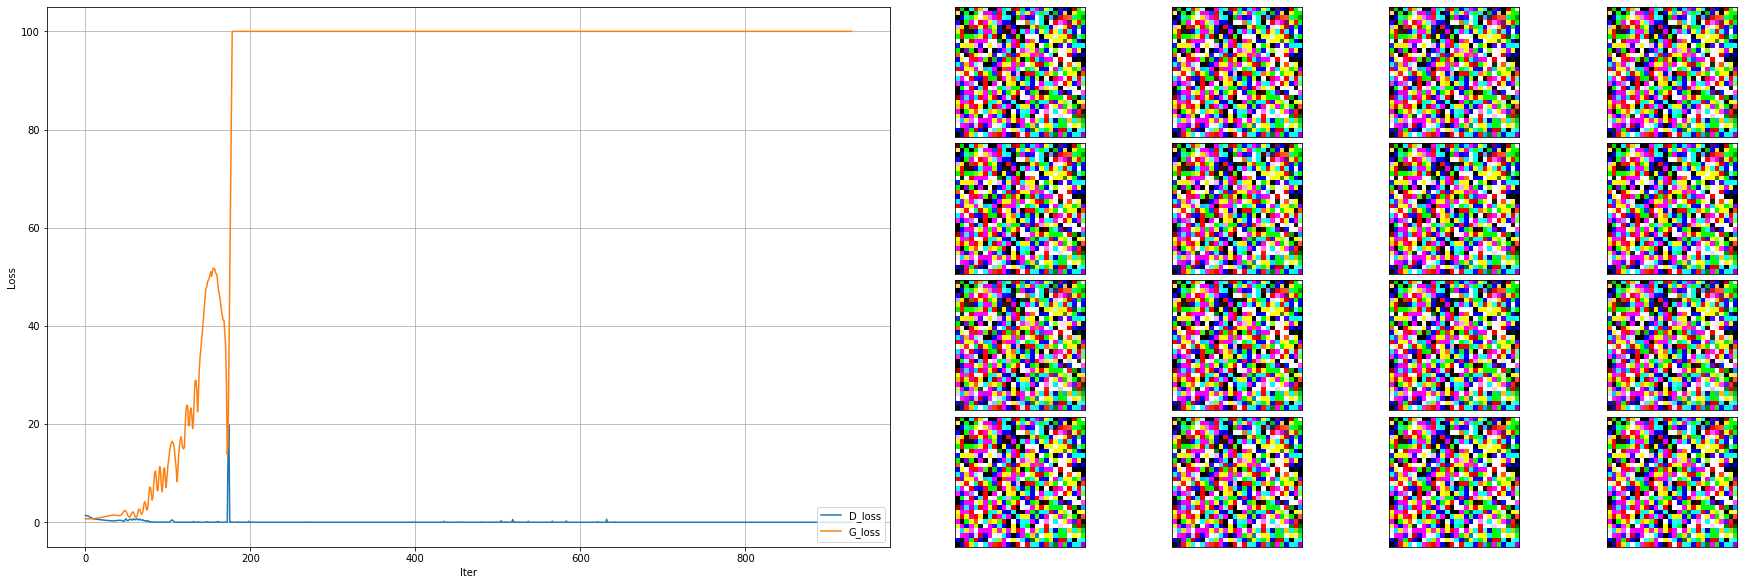

Training finish!
所要時間: 144.6362898349762


In [12]:
import time
time_sta = time.time()
gan5 = GAN_KFAC2(epoch=1, lrG=0.01, lrD=0.01, z_dim=10)
gan5.train()
time_end = time.time()
print("所要時間: {}".format(time_end - time_sta))

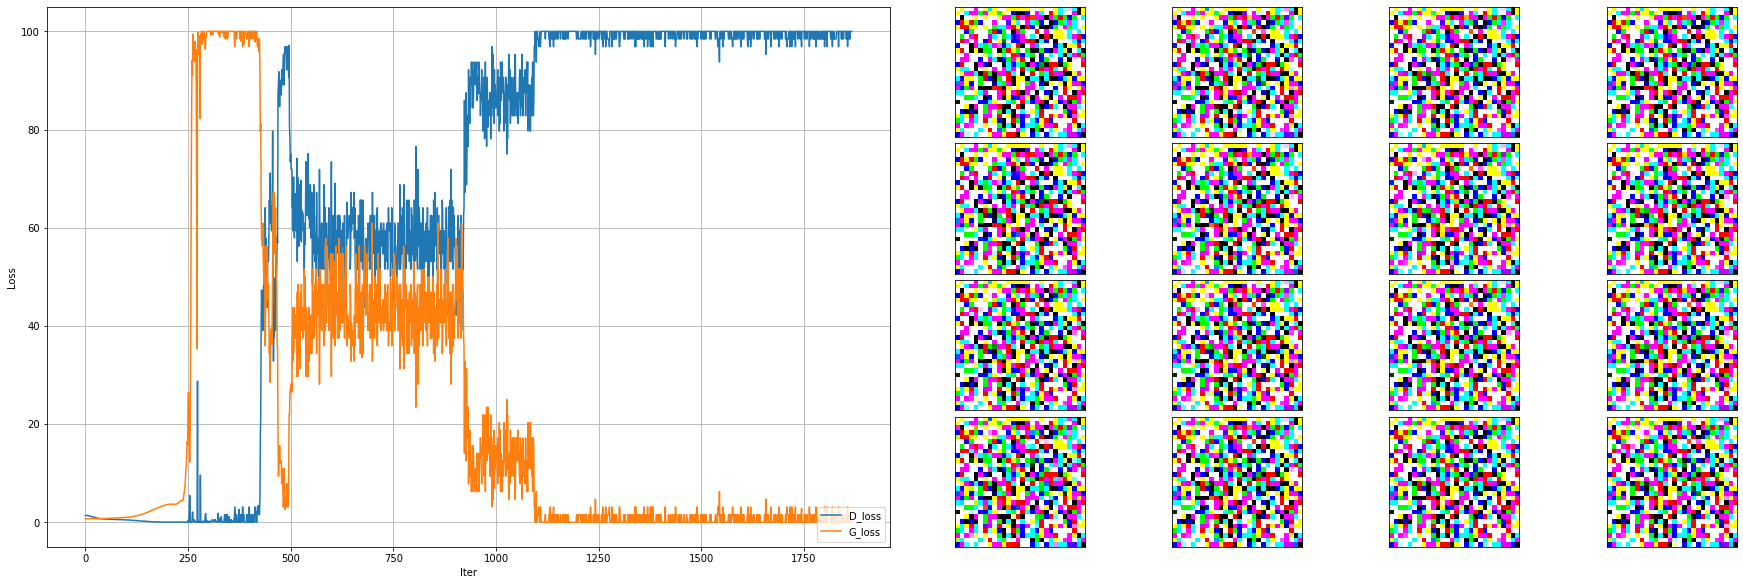

Training finish!
所要時間: 283.8902974128723


In [14]:
import time
time_sta = time.time()
gan6 = GAN_KFAC2(epoch=2, lrG=0.001, lrD=0.001, z_dim=100)
gan6.train()
time_end = time.time()
print("所要時間: {}".format(time_end - time_sta))

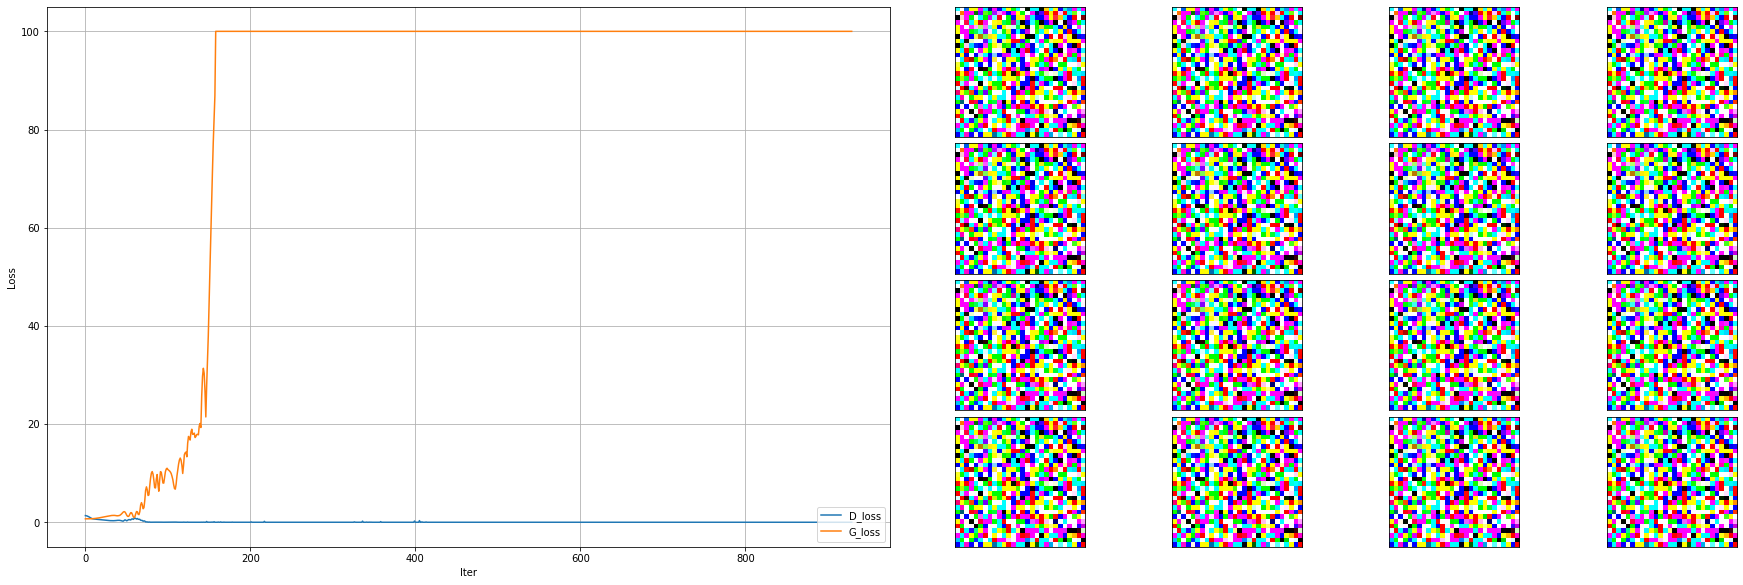

Training finish!
所要時間: 138.98580622673035


In [15]:
import time
time_sta = time.time()
gan7 = GAN_KFAC2(epoch=1, lrG=0.01, lrD=0.01, z_dim=100)
gan7.train()
time_end = time.time()
print("所要時間: {}".format(time_end - time_sta))

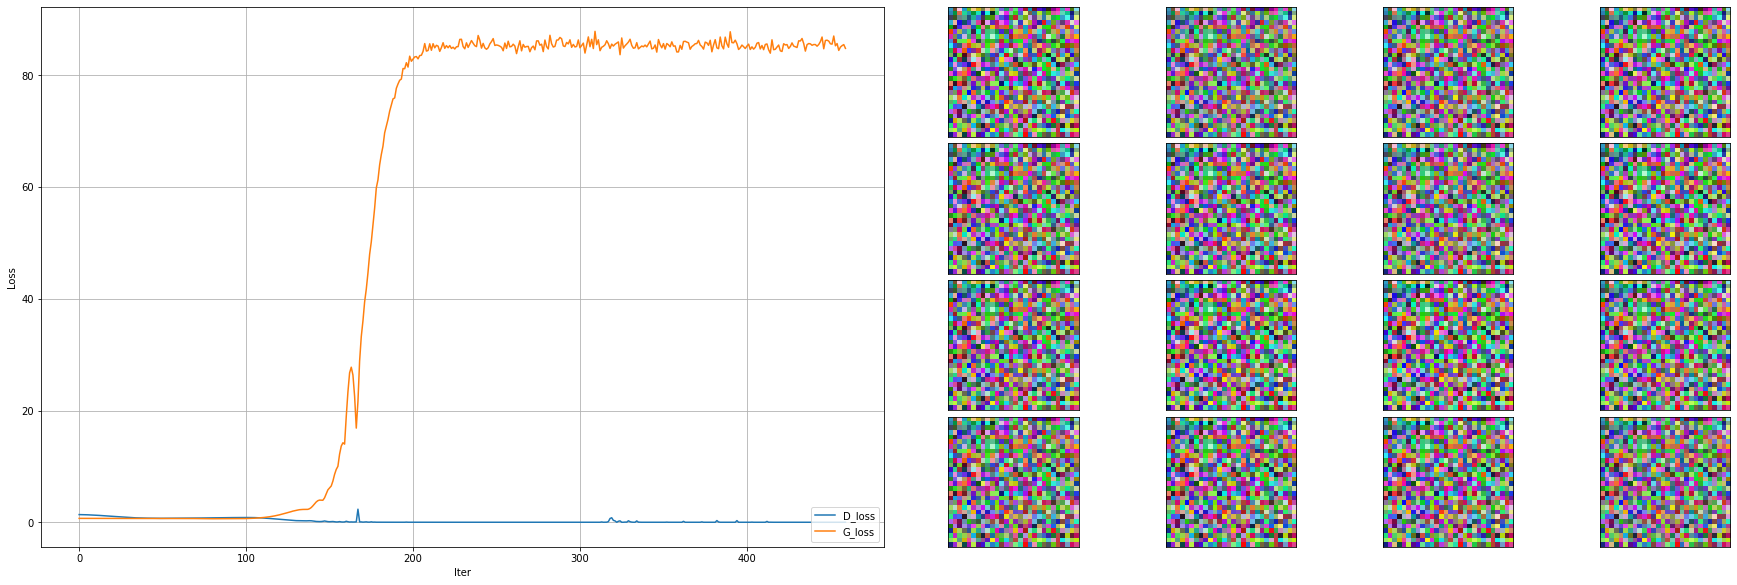

ValueError: ignored

<Figure size 432x288 with 0 Axes>

In [16]:
import time
time_sta = time.time()
gan8 = GAN_KFAC2(epoch=1, lrG=0.01, lrD=0.001, z_dim=100)
gan8.train()
time_end = time.time()
print("所要時間: {}".format(time_end - time_sta))

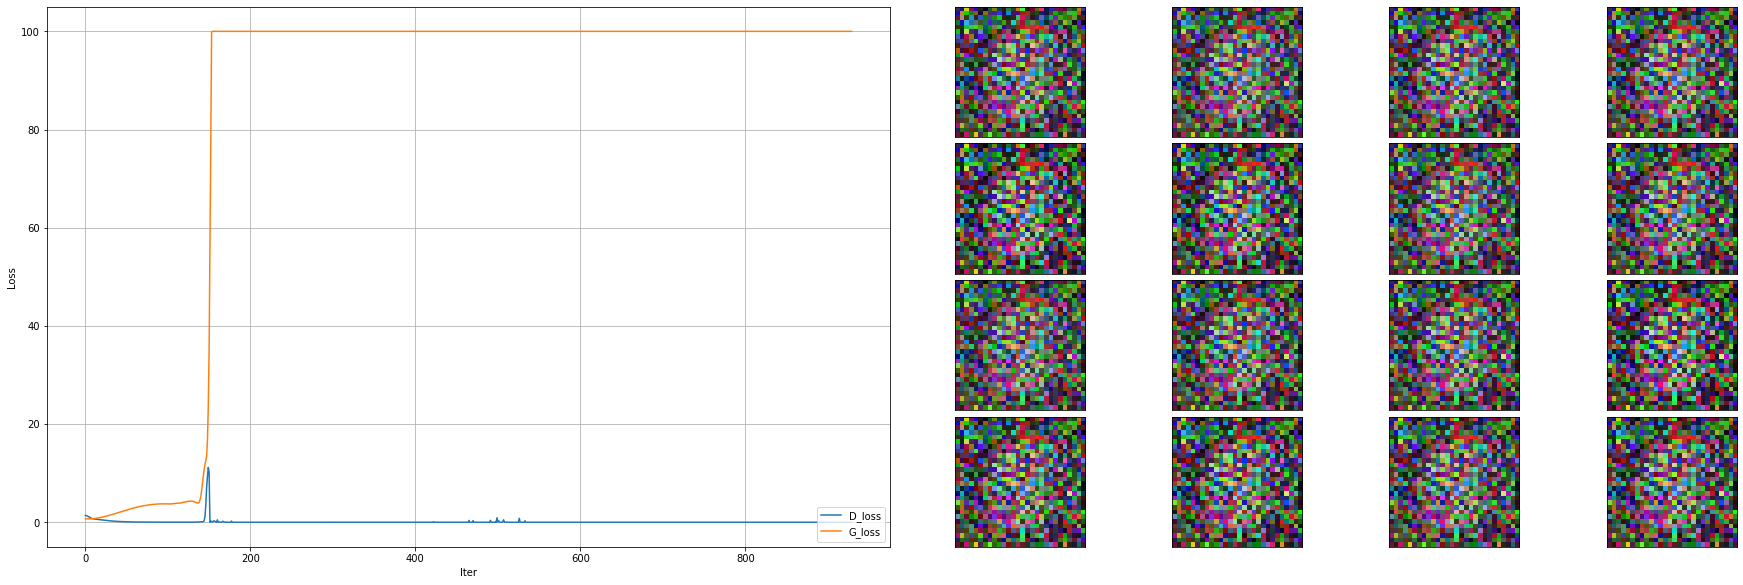

Training finish!
所要時間: 131.14078736305237


In [17]:
import time
time_sta = time.time()
gan9 = GAN_KFAC2(epoch=1, lrG=0.001, lrD=0.01, z_dim=100)
gan9.train()
time_end = time.time()
print("所要時間: {}".format(time_end - time_sta))

In [11]:
class GAN_KFAC_Adam(object):
    def __init__(self, dataset='mnist', epoch=1, sample_num=16, batch_size=64, input_size=28, z_dim=10, lrG=0.0001, lrD=0.0001, beta1=0.5, beta2=0.999):
        self.epoch = epoch
        self.sample_num = sample_num
        self.batch_size = batch_size
        self.input_size = input_size
        self.z_dim = z_dim
        self.lrG = lrG
        self.lrD = lrD
        self.beta1 = beta1
        self.beta2 = beta2
        self.dataset = dataset # mnist, fashion-mnist, cifar10

        # load dataset
        self.data_loader = dataloader(self.dataset, self.input_size, self.batch_size)
        data = self.data_loader.__iter__().__next__()[0]

        # networks init
        self.G = generator(input_dim=self.z_dim, output_dim=data.shape[1], input_size=self.input_size)
        self.D = discriminator(input_dim=data.shape[1], output_dim=1, input_size=self.input_size)
        self.G_optimizer = optim.Adam(self.G.parameters(), lr=self.lrG, betas=(self.beta1, self.beta2))
        self.D_optimizer = kfac.KFACOptimizer(self.D, lr=self.lrD)

        self.G.cuda()
        self.D.cuda()
        self.BCE_loss = nn.BCELoss().cuda()

        self.sample_z_ = torch.rand((self.batch_size, self.z_dim))
        self.sample_z_ = self.sample_z_.cuda()

    def train(self):
        self.train_hist = {}
        self.train_hist['D_loss'] = []
        self.train_hist['G_loss'] = []

        self.y_real_, self.y_fake_ = torch.ones(self.batch_size, 1), torch.zeros(self.batch_size, 1)
        self.y_real_, self.y_fake_ = self.y_real_.cuda(), self.y_fake_.cuda()

        self.D.train()
        for epoch in range(self.epoch):
            self.G.train()
            for iter, (x_, _) in enumerate(self.data_loader): # ( batch, 3, 28, 28 )
                if iter == self.data_loader.dataset.__len__() // self.batch_size:
                    break
                # zを一様分布からサンプリング
                # https://pytorch.org/docs/stable/generated/torch.rand.html
                z_ = torch.rand((self.batch_size, self.z_dim))
                x_, z_ = x_.cuda(), z_.cuda()

                # update D network
                self.D_optimizer.zero_grad()

                D_real = self.D(x_) # ( batch, 1 )
                # https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html
                # y_real_ = 1, y_fake_ = 0
                D_real_loss = self.BCE_loss(D_real, self.y_real_)

                G_ = self.G(z_)
                D_fake = self.D(G_)
                D_fake_loss = self.BCE_loss(D_fake, self.y_fake_)

                # 最大化→マイナスを取った値について最小化
                D_loss = D_real_loss + D_fake_loss
                self.train_hist['D_loss'].append(D_loss.item())

                D_loss.backward()
                self.D_optimizer.step()

                # update G network
                self.G_optimizer.zero_grad()

                G_ = self.G(z_)
                D_fake = self.D(G_)
                # GAN originalではなく, 勾配が消えないように工夫したloss, そのため第二引数がy_real(=1)
                # https://github.com/soumith/ganhacks のtip2
                G_loss = self.BCE_loss(D_fake, self.y_real_)
                self.train_hist['G_loss'].append(G_loss.item())

                G_loss.backward()
                self.G_optimizer.step()
                
                # ディスプレイ
                if ((iter + 1) % 10) == 0:
                    with torch.no_grad():
                        tot_num_samples = min(self.sample_num, self.batch_size)
                        image_frame_dim = int(np.floor(np.sqrt(tot_num_samples)))
                        display_process(self.train_hist, self.G, image_frame_dim, self.sample_z_)
                        display.clear_output(wait=True)
                        display.display(pl.gcf())
                        plt.close()
                       
        plt.close()
        print("Training finish!")

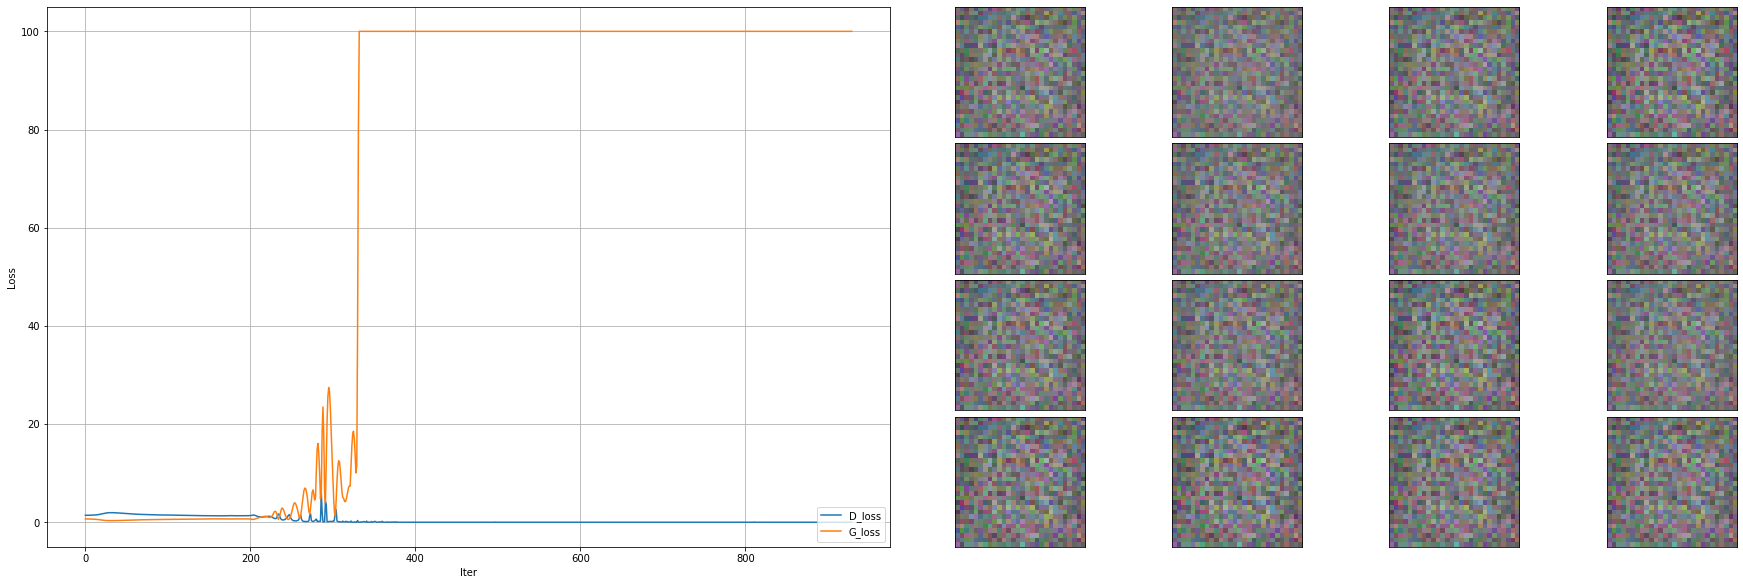

Training finish!
所要時間: 118.03053092956543


In [12]:
import time
time_sta = time.time()
gan10 = GAN_KFAC_Adam(epoch=1, z_dim=100)
gan10.train()
time_end = time.time()
print("所要時間: {}".format(time_end - time_sta))